In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [4]:
TARGET_COLUMN = 'vocal_channel'

In [5]:
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

In [6]:
one_hot = pd.get_dummies(df[TARGET_COLUMN])
df = df.join(one_hot)
df = df.drop([TARGET_COLUMN], axis=1)

In [7]:
def plot_percentage(data, columns, save_as=None):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=(10, 6))
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    if save_as is not None:
        plt.savefig(os.path.join(IMAGE_FOLDER, save_as), format='pdf')
    plt.show()

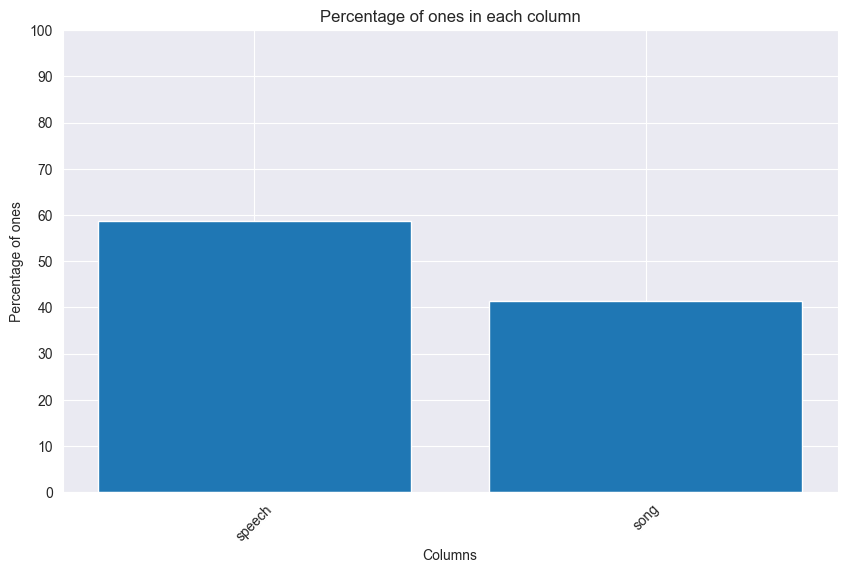

In [8]:
plot_percentage(df, values, save_as='imblearn_initial_percentage.pdf')

## Visualize the target class

In [9]:
TARGET_CLASS = 'song'

In [10]:
from matplotlib.cm import get_cmap
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_class(data, values_list, value, save_as=None):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)


    plt.figure(figsize=(8, 6))


    colors = [plt.cm.Paired(i) for i in range(12)]

    mask = (data[value] == 0)
    plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[0])

    mask = (data[value] == 1)
    plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[7])

    plt.axis('off')
    plt.tight_layout()
    if save_as is not None:
        plt.savefig(os.path.join(IMAGE_FOLDER, save_as), format='pdf')
    plt.show()

In [11]:
from sklearn.decomposition import PCA

def pca_by_class(data, values_list, value, save_as=None):

    data2 = data.drop(values_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))

    colors = [plt.cm.Paired(i) for i in range(12)]

    mask = (data[value] == 0)
    plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[0])

    mask = (data[value] == 1)
    plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[7])

    plt.axis('off')
    plt.tight_layout()
    if save_as is not None:
        plt.savefig(os.path.join(IMAGE_FOLDER, save_as), format='pdf')
    plt.show()

In [12]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

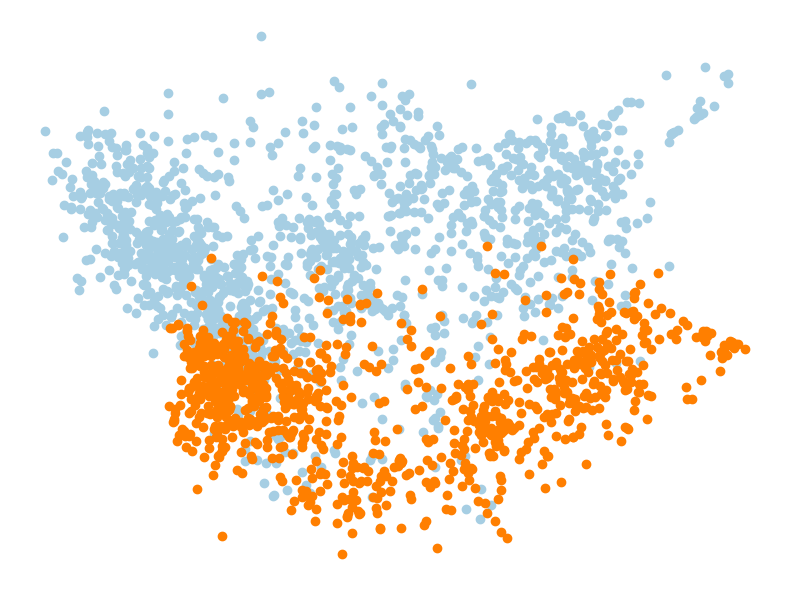

In [13]:
isomap_by_class(df[numerical_attr_list], values, TARGET_CLASS)

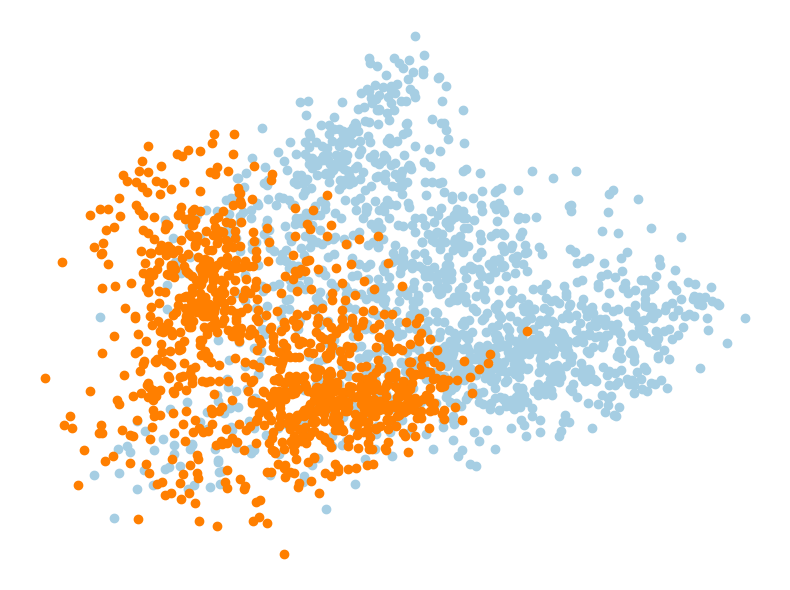

In [14]:
pca_by_class(df[numerical_attr_list], values, TARGET_CLASS)

## Dataset imbalance

In [15]:
split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df[:split_index]
df_test = df[split_index:]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
target_class_count = df_train[TARGET_CLASS].sum()
other_class_count = df_train.shape[0] - target_class_count
eight_percent = int(other_class_count * 8 / 100)

# target class is 8% the size of the other one
rows_to_keep = np.random.choice(df_train[df_train[TARGET_CLASS] == 1].index, eight_percent, replace=False)
df_train = df_train[(df_train[TARGET_CLASS] == 1 & df_train.index.isin(rows_to_keep)) | (df_train[TARGET_CLASS] == 0)]

df_train = df_train.reset_index(drop=True)

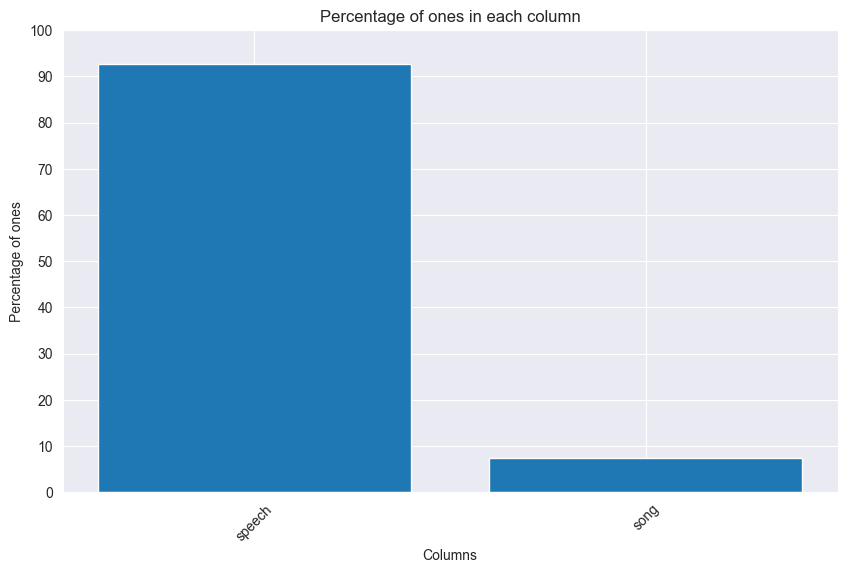

In [17]:
plot_percentage(df_train, values, save_as='imblearn_final_percentage.pdf')

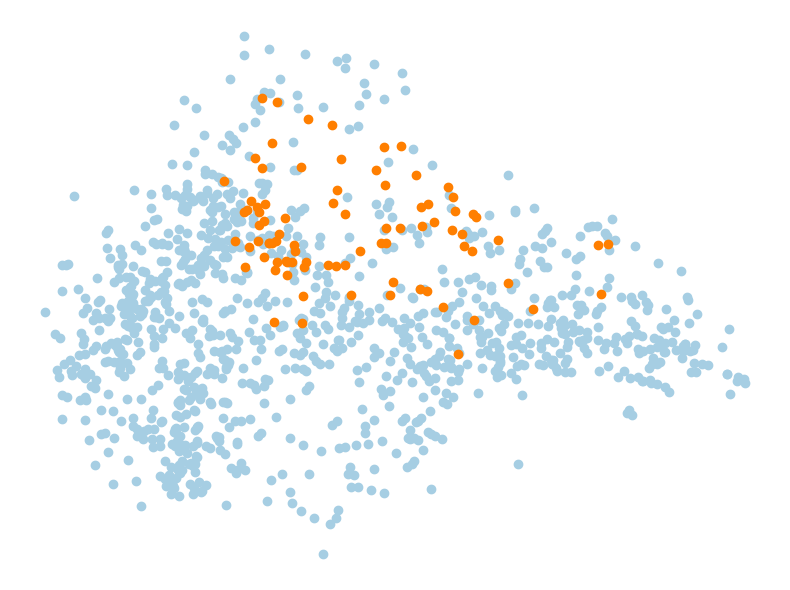

In [18]:
isomap_by_class(df_train[numerical_attr_list], values, TARGET_CLASS, save_as='imblearn_scatter_isomap.pdf')

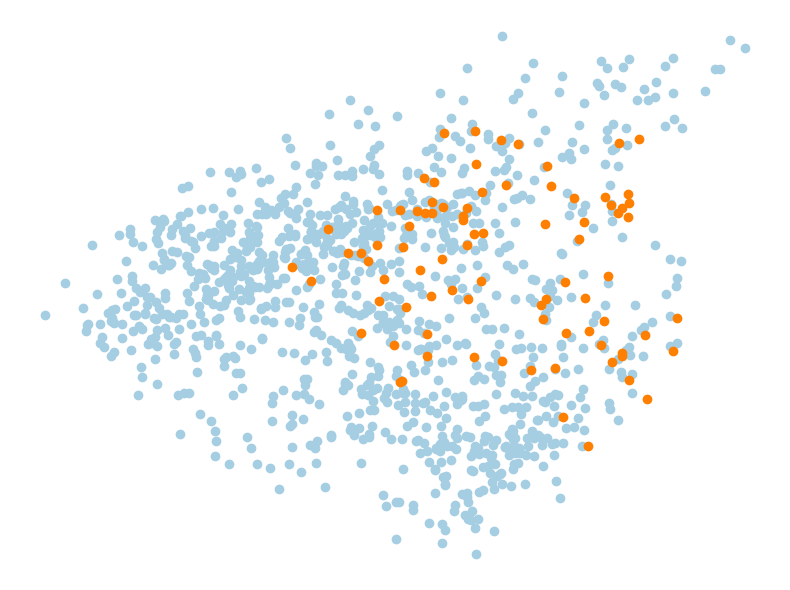

In [19]:
pca_by_class(df_train[numerical_attr_list], values, TARGET_CLASS, save_as='imblearn_scatter_PCA.pdf')

# Dataset preparation

In [20]:
target_train = df_train[TARGET_CLASS]
target_test = df_test[TARGET_CLASS]

display(df_train.shape, df_test.shape)

(1156, 251)

(617, 251)

In [21]:
excluded_prefixes = ['zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(values, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)) and column != TARGET_COLUMN:
        columns_to_keep.append(column)

# selected features without target
columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_q25',
 'lag1_q75',
 'lag1_skew',
 'mfcc_sum',
 'mfcc_mean',
 'mfcc_std',
 'mfcc_min',
 'mfcc_max',
 'mfcc_q01',
 'mfcc_q05',
 'mfcc_q25',
 'mfcc_q50',
 'mfcc_q75',
 'mfcc_q95',
 'mfcc_q99',
 'mfcc_kur',
 'mfcc_skew',
 'sc_sum',
 'sc_mean',
 'sc_std',
 'sc_min',
 'sc_max',
 'sc_q01',
 'sc_q05',
 'sc_q25',
 'sc_q50',
 'sc_q75',
 'sc_q95',
 'sc_q99',
 'sc_kur',
 'sc_skew',
 'stft_sum',
 'stft_mean',
 'stft_std',
 'stft_min',
 'stft_q01',
 'stft_q05',
 'stft_q25',
 'stft_q50',
 'stft_q75',
 'stft_kur',
 'stft_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_sum_w1',
 'lag1_max_w1',
 'lag1_q95_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'mfcc_sum_w1',
 'mfcc_mean_w1',
 'mfcc_std_w1',
 'mfcc_min_w1',
 'mfcc_max_w1',
 'mfcc_q05_w1',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'mfcc_q75_w1',
 'mfcc_q95_w1',
 'mfcc_q99_w1',
 'mfcc_kur_w1',
 'mfcc_sk

In [22]:
df_train = df_train.drop(df_train.columns.difference(columns_to_keep), axis=1)
df_test = df_test.drop(df_test.columns.difference(columns_to_keep), axis=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [23]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_test = target_test.to_numpy()

# Undersampling
## CNN

In [24]:
from collections import Counter
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1)
X_res, y_res = cnn.fit_resample(X_train, y_train)

print(f'Starting dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_res)}')

Starting dataset shape Counter({False: 1071, True: 85})
Resampled dataset shape Counter({True: 85, False: 65})


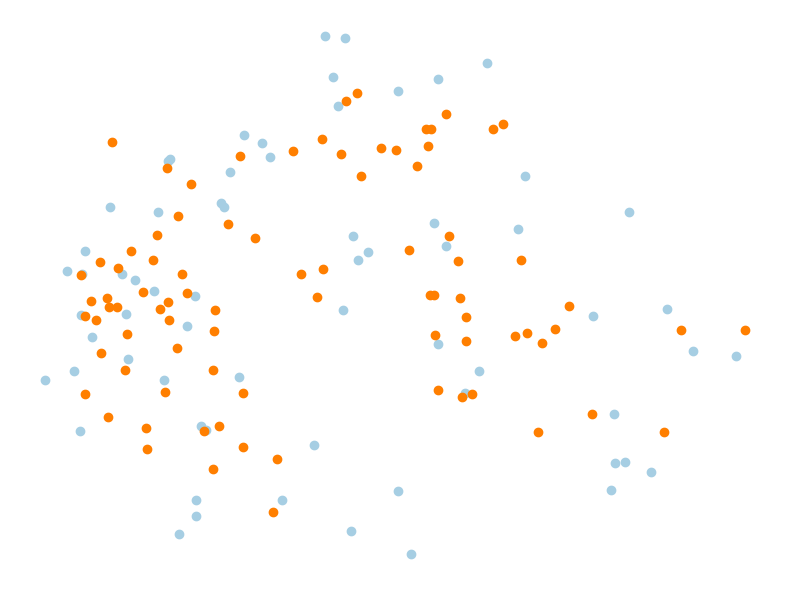

In [25]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res)

plt.figure(figsize=(8, 6))

colors = [plt.cm.Paired(i) for i in range(12)]

mask = (y_res == 0)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[0])

mask = (y_res == 1)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[7])

#plt.scatter(embedding[:, 0], embedding[:, 1], c=y_res, cmap='Paired')
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_undersampling_isomap.pdf'), format='pdf')
plt.show()

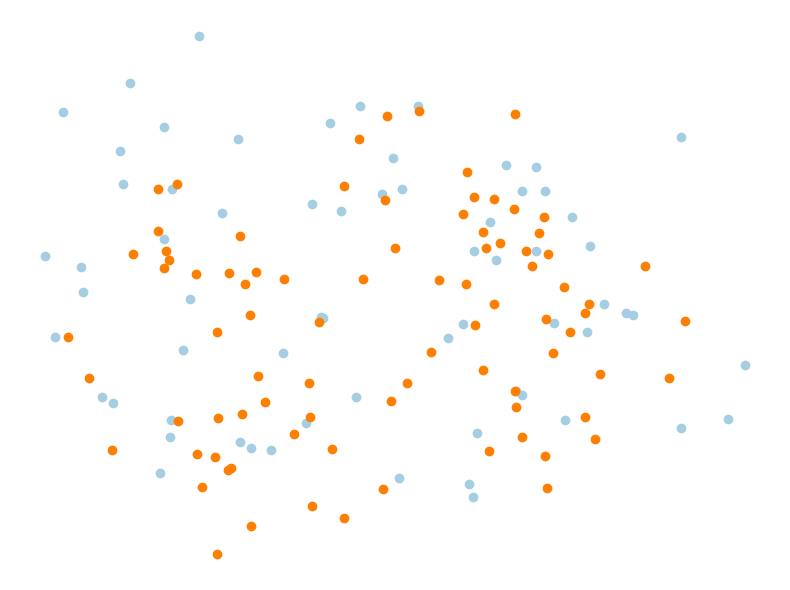

In [26]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res)

plt.figure(figsize=(8, 6))

colors = [plt.cm.Paired(i) for i in range(12)]

mask = (y_res == 0)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[0])

mask = (y_res == 1)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[7])

plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_undersampling_PCA.pdf'), format='pdf')
plt.show()

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

param_grid = {
    'n_neighbors': np.arange(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_res, y_res)
clf = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'} 0.8513333333333334


In [28]:
clf.score(X_test, y_test)

0.9562398703403565

In [29]:
from sklearn.metrics import classification_report

y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.96      0.97      0.96       355
        True       0.96      0.94      0.95       262

    accuracy                           0.96       617
   macro avg       0.96      0.95      0.96       617
weighted avg       0.96      0.96      0.96       617



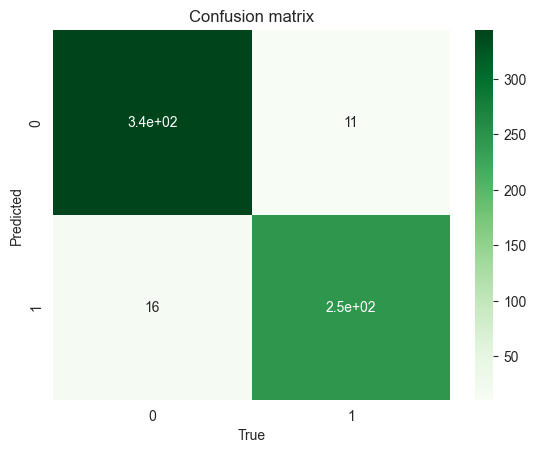

In [30]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_undersampling_heatmap.pdf'), format='pdf')
plt.show()

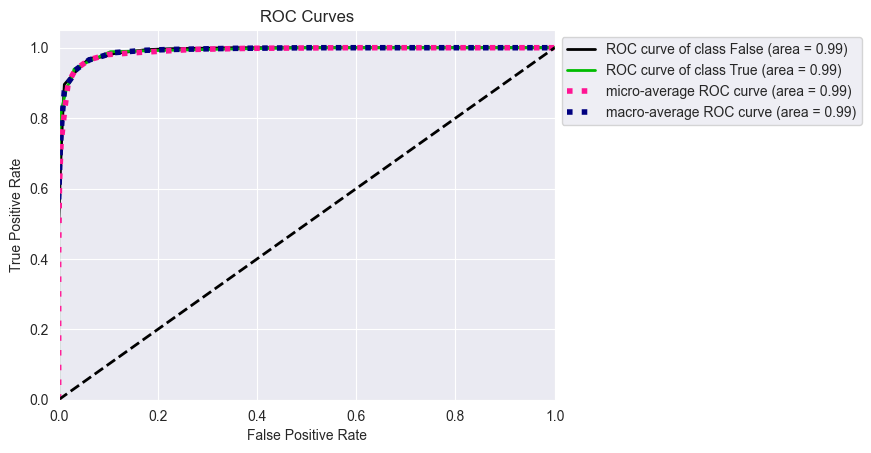

0.9910654768304483


In [31]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc

y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_undersampling_roc_curves.pdf'), format='pdf')
plt.show()
print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

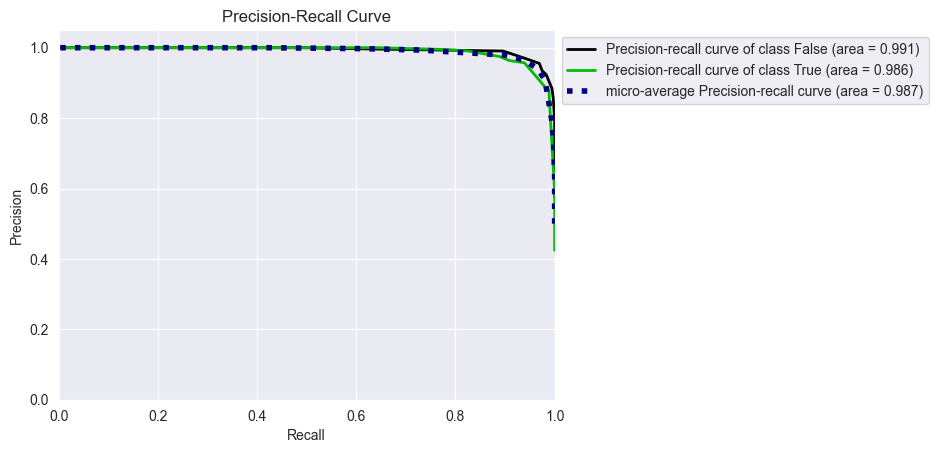

In [32]:
from scikitplot.metrics import plot_precision_recall

plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_undersampling_precision_recall_curves.pdf'), format='pdf')
plt.show()

# Oversampling
## SMOTE

In [33]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print(f'Starting dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_res)}')

Starting dataset shape Counter({False: 1071, True: 85})
Resampled dataset shape Counter({False: 1071, True: 1071})


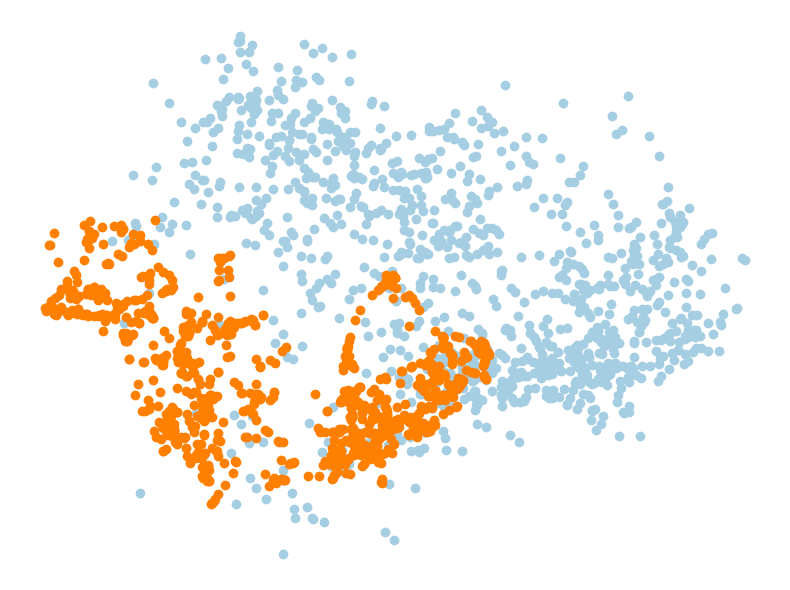

In [34]:
isomap = Isomap(n_components=2, n_neighbors=10)
embedding = isomap.fit_transform(X_res)

plt.figure(figsize=(8, 6))
colors = [plt.cm.Paired(i) for i in range(12)]

mask = (y_res == 0)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[0])

mask = (y_res == 1)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[7])

plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_oversampling_isomap.pdf'), format='pdf')
plt.show()

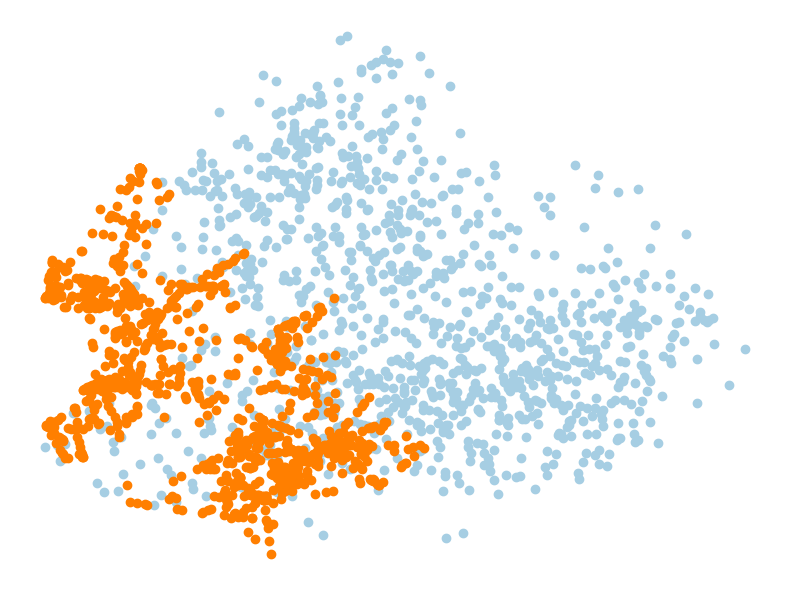

In [35]:
pca = PCA(n_components=2)
embedding = pca.fit_transform(X_res)

plt.figure(figsize=(8, 6))

colors = [plt.cm.Paired(i) for i in range(12)]

mask = (y_res == 0)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[0])

mask = (y_res == 1)
plt.scatter(embedding[:, 0][mask], embedding[:, 1][mask], color=colors[7])

plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_oversampling_PCA.pdf'), format='pdf')
plt.show()

In [36]:
param_grid = {
    'n_neighbors': np.arange(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_res, y_res)
clf = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'} 0.9947249635100102


In [37]:
clf.score(X_test, y_test)

0.9448946515397083

In [38]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.94      0.97      0.95       355
        True       0.96      0.91      0.93       262

    accuracy                           0.94       617
   macro avg       0.95      0.94      0.94       617
weighted avg       0.95      0.94      0.94       617



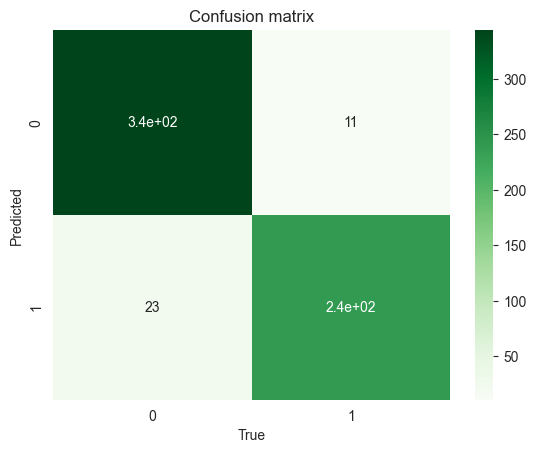

In [39]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion matrix')
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_oversampling_heatmap.pdf'), format='pdf')
plt.show()

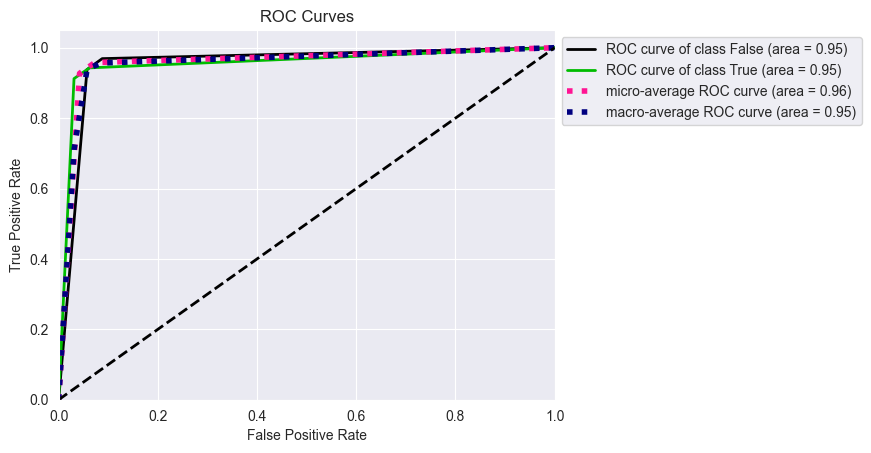

0.9540479518331362


In [40]:
y_test_pred_proba = clf.predict_proba(X_test)
plot_roc(y_test, y_test_pred_proba)
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_oversampling_roc_curves.pdf'), format='pdf')
plt.show()

print(roc_auc_score(y_test, y_test_pred_proba[:, 1], multi_class='ovr', average='macro'))

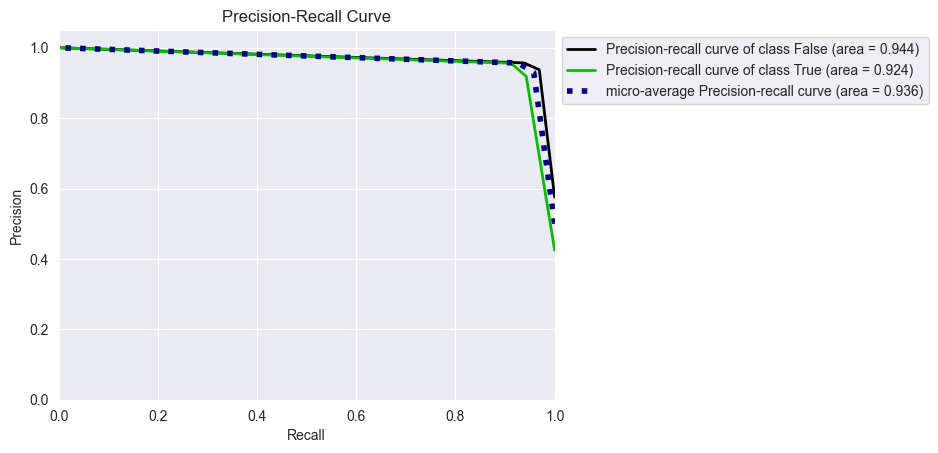

In [41]:
plot_precision_recall(y_test, clf.predict_proba(X_test))
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(os.path.join(IMAGE_FOLDER, 'imblearn_oversampling_precision_recall_curves.pdf'), format='pdf')
plt.show()